## The purpose of this notebook is to test the Layerwise Relevance Propagation on the QuakeXNet model

In [3]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

from neural_network_architectures import QuakeXNet_1d
from neural_network_architectures import QuakeXNet_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import BasicResNet_1d
from neural_network_architectures import BasicResNet_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr

cuda
cuda
cuda


In [2]:
#data files
file_noise="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


In [3]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

In [4]:
num_channels = 3
number_data_per_class = 8434
lowcut = 1
highcut = 20
fs = 50
nos = 2000
all_data = False
start = -20
shifting = True
input_window_length = 100

# training parameters
train_split = 70
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

In [5]:
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)

# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)



# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)


  0%|          | 6/8434 [00:00<02:37, 53.56it/s]

(3712, 3, 5000)


  0%|          | 6/8434 [00:00<02:26, 57.45it/s]

(5921, 3, 5000)


  0%|          | 6/8434 [00:00<02:23, 58.81it/s]

(6234, 3, 5000)


100%|██████████| 8434/8434 [02:04<00:00, 67.58it/s]


(5636, 3, 5000)


In [10]:
a = extract_spectrograms(waveforms = d_su[0:2])

100%|██████████| 2/2 [00:00<00:00, 1007.16it/s]

(2, 3, 129, 38)


In [ ]:
def extract_spectrograms(waveforms = a, fs = fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)  # Calculate overlap

    # Example of how to get the shape of one spectrogram
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

    # Initialize an array of zeros with the shape: (number of waveforms, channels, frequencies, time_segments)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in tqdm(range(waveforms.shape[0])):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs)
            spectrograms[i, j] = Sxx  # Fill the pre-initialized array

    print(spectrograms.shape)
    return spectrograms

In [31]:
fs = 50
waveforms = d_su[0:2]
f,t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=256, noverlap=128, fs=fs)

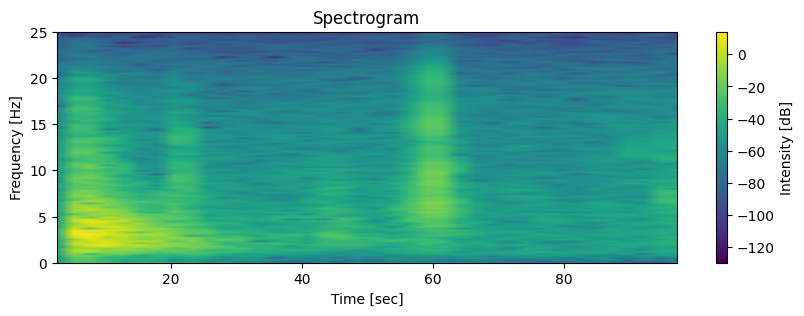

In [45]:
import matplotlib.pyplot as plt
from scipy import signal

# Assuming fs, waveforms, f, t, and Sxx are already defined as in your code
fs = 50
waveforms = d_su[0:1]
f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=256, noverlap=128, fs=fs)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [4]:
## Original QuakeXNet architecture.
class QuakeXNet_2d(nn.Module):
    def __init__(self, num_classes=4, num_channels=3, dropout_rate=0.2):
        super(QuakeXNet_2d, self).__init__()
        
        # Define the layers of the CNN architecture
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Batch-normalization layers
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(32)
        self.bn7 = nn.BatchNorm2d(64)

        # Calculate the input size for the fully connected layer dynamically
        self.fc_input_size = self._get_conv_output_size(num_channels, (129, 38))
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)

        # Define dropout
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output_size(self, num_channels, input_dims):
        # Forward pass a dummy input through the conv layers to get the output size
        dummy_input = torch.randn(1, num_channels, *input_dims)
        with torch.no_grad():
            x = F.relu(self.bn1(self.conv1(dummy_input)))
            x = self.pool1(F.relu(self.bn2(self.conv2(x))))
            x = F.relu(self.bn3(self.conv3(x)))
            x = self.pool1(F.relu(self.bn4(self.conv4(x))))
            x = F.relu(self.bn5(self.conv5(x)))
            x = F.relu(self.bn6(self.conv6(x)))
            x = F.relu(self.bn7(self.conv7(x)))
        return x.numel()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # output size: (8, 129, 38)
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))  # output size: (8, 64, 19)
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))  # output size: (16, 64, 19)
        x = self.pool1(F.relu(self.bn4(self.conv4(x))))  # output size: (16, 32, 10)
        x = self.dropout(x)
        
        x = F.relu(self.bn5(self.conv5(x)))  # output size: (32, 32, 10)
        x = F.relu(self.bn6(self.conv6(x)))  # output size: (32, 16, 5)
        x = self.dropout(x)
        
        x = F.relu(self.bn7(self.conv7(x)))  # output size: (64, 16, 5)
        
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer
        x = self.dropout(x)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))  # classifier
        x = self.fc2_bn(self.fc2(x))  # classifier
        
        # Do not apply softmax here, as it will be applied in the loss function
        return x

    


In [73]:
#%% QuakeXNet 2D architecture without batchnorm layers that makes it hard to perform lrp

class QuakeXNet_2d_no_bn(nn.Module):
    def __init__(self, num_classes=4, num_channels=3, dropout_rate=0.2):
        super(QuakeXNet_2d_no_bn, self).__init__()
        
        # Define the layers of the CNN architecture
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Calculate the input size for the fully connected layer dynamically
        self.fc_input_size = self._get_conv_output_size(num_channels, (129, 38))
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Define dropout
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output_size(self, num_channels, input_dims):
        # Forward pass a dummy input through the conv layers to get the output size
        dummy_input = torch.randn(1, num_channels, *input_dims).to(device)
        with torch.no_grad():
            x = F.relu(self.conv1(dummy_input))
            x = self.pool1(F.relu(self.conv2(x)))
            x = F.relu(self.conv3(x))
            x = self.pool1(F.relu(self.conv4(x)))
            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            x = F.relu(self.conv7(x))
        return x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))  # output size: (8, 129, 38)
        x = self.pool1(F.relu(self.conv2(x)))  # output size: (8, 64, 19)
        x = self.dropout(x)
        
        x = F.relu(self.conv3(x))  # output size: (16, 64, 19)
        x = self.pool1(F.relu(self.conv4(x)))  # output size: (16, 32, 10)
        x = self.dropout(x)
        
        x = F.relu(self.conv5(x))  # output size: (32, 32, 10)
        x = F.relu(self.conv6(x))  # output size: (32, 16, 5)
        x = self.dropout(x)
        
        x = F.relu(self.conv7(x))  # output size: (64, 16, 5)
        
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))  # classifier
        x = self.fc2(x)  # classifier
        
        # Do not apply softmax here, as it will be applied in the loss function
        return x

    


In [7]:
# The model QuakeXNet_2d_no_bn takes the input of following shape - (batch_size, num_channels, frequency, time)

### Let's first train the QuakeXNet_2d_no_bn model

In [10]:
#data files
file_noise="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


In [11]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

In [12]:
num_channels = 3
number_data_per_class = 8434 ## This is equal to the total number of the samples in the minority class.

# new sampling rate
fs = 50

nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = -20
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100


# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)

# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)



# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)


  0%|          | 8/8434 [00:00<01:46, 78.89it/s]

(3712, 3, 5000)


  0%|          | 14/8434 [00:00<01:01, 137.75it/s]

(5975, 3, 5000)


  0%|          | 7/8434 [00:00<02:01, 69.43it/s]

(6226, 3, 5000)


100%|██████████| 8434/8434 [02:02<00:00, 69.03it/s]


(5640, 3, 5000)


In [14]:
s_su = extract_spectrograms(waveforms = d_su[0:nos])
s_noise = extract_spectrograms(waveforms = d_noise[0:nos])
s_eq = extract_spectrograms(waveforms = d_eq[0:nos])
s_exp = extract_spectrograms(waveforms = d_exp[0:nos])

# concatenate all data into one input
X_2d = np.vstack([s_eq, s_exp, s_noise, s_su])


y = [0]*len(d_eq[0:nos])+[1]*len(d_exp[0:nos])+[2]*len(d_noise[0:nos])+[3]*len(d_su[0:nos])

## Preparing the data loaders for 1d and 2d inputs
#train_loader_1d, val_loader_1d, test_loader_1d = return_train_test_val_loaders(X = X_1d, y = y, train_split = train_split, test_split = test_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d, test_loader_2d = return_train_test_val_loaders(X = X_2d, y = y, train_split = train_split, test_split = test_split, val_split = val_split, batch_size = batch_size)

  0%|          | 0/2000 [00:00<?, ?it/s]

  7%|▋         | 138/2000 [00:00<00:01, 1373.22it/s]

(2000, 3, 129, 38)


  7%|▋         | 137/2000 [00:00<00:01, 1365.39it/s]

(2000, 3, 129, 38)


  7%|▋         | 136/2000 [00:00<00:01, 1349.47it/s]

(2000, 3, 129, 38)


100%|██████████| 2000/2000 [00:01<00:00, 1357.41it/s]


(2000, 3, 129, 38)
43 12 6


In [47]:
n_epochs = 100
model_quakexnet_2d_no_bn = QuakeXNet_2d_no_bn(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_quakexnet_2d_no_bn, val_loss_time_quakexnet_2d_no_bn, val_accuracy_time_quakexnet_2d_no_bn,test_loss_quakexnet_2d_no_bn,test_accuracy_quakexnet_2d_no_bn) = train_model(model_quakexnet_2d_no_bn,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 10%|█         | 10/100 [00:05<00:49,  1.83it/s]

[Epoch 10] loss: 0.662 - accuracy: 74.154


 20%|██        | 20/100 [00:11<00:44,  1.79it/s]

[Epoch 20] loss: 0.579 - accuracy: 80.013


 30%|███       | 30/100 [00:16<00:38,  1.81it/s]

[Epoch 30] loss: 0.519 - accuracy: 81.380


 40%|████      | 40/100 [00:22<00:32,  1.82it/s]

[Epoch 40] loss: 0.488 - accuracy: 81.706


 50%|█████     | 50/100 [00:27<00:27,  1.84it/s]

[Epoch 50] loss: 0.458 - accuracy: 83.464


 60%|██████    | 60/100 [00:32<00:21,  1.85it/s]

[Epoch 60] loss: 0.446 - accuracy: 82.878


 70%|███████   | 70/100 [00:38<00:16,  1.84it/s]

[Epoch 70] loss: 0.414 - accuracy: 85.221


 80%|████████  | 80/100 [00:43<00:10,  1.84it/s]

[Epoch 80] loss: 0.399 - accuracy: 84.896


 90%|█████████ | 90/100 [00:49<00:05,  1.83it/s]

[Epoch 90] loss: 0.385 - accuracy: 86.719


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]

[Epoch 100] loss: 0.382 - accuracy: 84.831
test loss: 0.369 and accuracy: 87.500



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

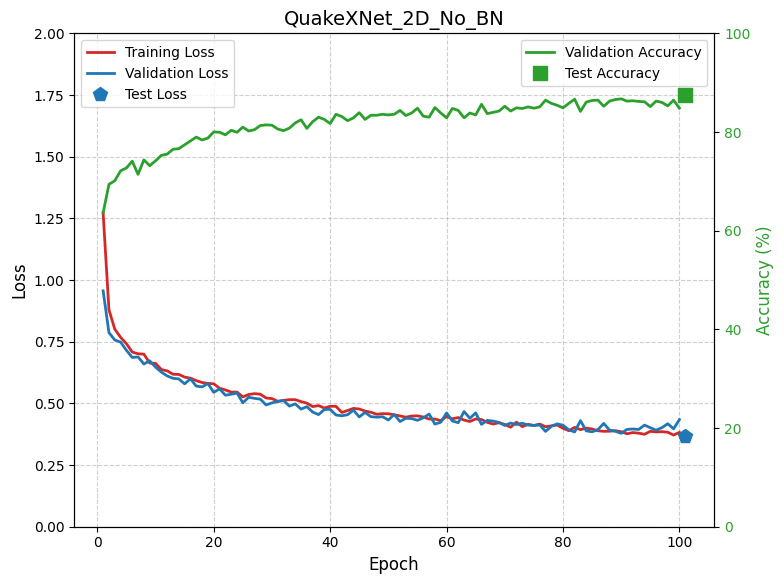

In [48]:
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN+1), loss_time[:NN], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN+1), val_loss_time[:NN], color='tab:blue', label='Validation Loss', linewidth=2)
    ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN+1), val_accuracy_time[:NN], color='tab:green', label='Validation Accuracy', linewidth=2)
    ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Save the figure with high resolution
    plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

plot_model_training(loss_time_quakexnet_2d_no_bn, val_loss_time_quakexnet_2d_no_bn, val_accuracy_time_quakexnet_2d_no_bn, test_loss_quakexnet_2d_no_bn, test_accuracy_quakexnet_2d_no_bn, title = 'QuakeXNet_2D_No_BN')

In [49]:
## Applying the LRP
model = model_quakexnet_2d_no_bn.eval()
model.to(device)

QuakeXNet_2d_no_bn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
# Utility function to clone layers and apply custom transformations
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try:
        layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError:
        pass
    try:
        layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError:
        pass
    return layer

# Function to convert dense layers to convolutional layers (same as in VGG16 case)
def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 64, layer.weight.shape[0]
                newlayer = nn.Conv2d(m, n, 1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n, m, 1, 1))
            else:
                m, n = layer.weight.shape[1], layer.weight.shape[0]
                newlayer = nn.Conv2d(m, n, 1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n, m, 1, 1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers




In [52]:
# Utility function to clone layers and apply custom transformations
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try:
        layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError:
        pass
    try:
        layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError:
        pass
    return layer



# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device (GPU if available, otherwise CPU)
model = model.to(device)


# Check if the model is on GPU (CUDA)
if next(model.parameters()).is_cuda:
    print("The model is on CUDA (GPU).")
else:
    print("The model is on CPU.")






# LRP for QuakeXNet_2d_no_bn model
def apply_lrp_on_quakeXNet(model, image, device):
    image = torch.unsqueeze(image, 0).to(device)  # Add batch dimension
    
    # Extract layers from model (skip batchnorm layers)
    layers = [
        model.conv1, model.conv2, model.conv3, model.conv4,
        model.conv5, model.conv6, model.conv7, model.pool1,
        model.fc1, model.fc2
    ]
    
    linear_layer_indices = [8,9]  # Index for fully connected layers

    # Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers  # List of activations
   
    for layer in range(n_layers):
        if layer in linear_layer_indices:
            activations[layer] = activations[layer].reshape((32, 32, 1, 1))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.MaxPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # Step 3: Replace last layer with one-hot encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    
    for layer in range(n_layers-1, -1, -1):
        current = layers[layer]
        
        # Apply LRP for different layers
        if isinstance(current, torch.nn.Conv2d) or isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply different rules based on layer depth
            if layer <= 3:  # Early layers (Conv layers)
                rho = lambda p: p + 0.25 * p.clamp(min=0)
                incr = lambda z: z + 1e-9
            elif 4 <= layer <= 7:  # Middle layers
                rho = lambda p: p
                incr = lambda z: z + 1e-9 + 0.25 * ((z ** 2).mean() ** 0.5).data
            else:  # Fully connected layers
                rho = lambda p: p
                incr = lambda z: z + 1e-9

            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer], rho).forward(activations[layer]))
            s = (relevances[layer+1] / z).data
            (z * s).sum().backward()  # Calculate the gradient
            c = activations[layer].grad
            
            # Assign new relevance values
            relevances[layer] = (activations[layer] * c).data
        else:
            relevances[layer] = relevances[layer + 1]

    # Step 5: Return the relevance for the input image
    return relevances[0]


image = torch.randn(3, 129, 38)  # Example input image (3 channels, 129x38 size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = next(iter(test_loader_2d))[0][0].to(device)
image_relevances = apply_lrp_on_quakeXNet(model, image, device)

# Visualizing the relevance scores
image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))

# Plot the results
plt.axis('off')
plt.imshow(image_relevances[:, :, 0], cmap="seismic")
plt.show()

The model is on CUDA (GPU).


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x1 and 256x128)

In [56]:
dense_to_conv([model.fc1, model.fc2])

RuntimeError: shape '[128, 64, 1, 1]' is invalid for input of size 32768

In [46]:
# Check if the model is on GPU (CUDA)
if next(model.parameters()).is_cuda:
    print("The model is on CUDA (GPU).")
else:
    print("The model is on CPU.")


The model is on CPU.


In [59]:
len(model.fc1.weight[0])

256

In [62]:
model.fc1.weight.shape

torch.Size([128, 256])

In [65]:
model.pool1

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [72]:
model._get_conv_output_size(3, (129, 38))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

8.0

In [47]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00a 0:00:01


4

In [ ]:
def compute_average_model_performance(num_iter = 10, model_name = "model_seismiccnn_1d", one_d = True, d_su = d_su, d_eq = d_eq, d_exp = d_exp, d_noise = d_noise, learning_rate = learning_rate, criterion = criterion):

    new_train_split = 70
    new_test_split = 28
    new_val_split = 2
    n_epochs = 100
    batch_size = 128


    nos = 3500
    avg_cm = []
    
    for i in range(num_iter):
        
            
        if model_name == "model_seismiccnn_1d":
            model = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_seismiccnn_2d":
            model = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_mycnn_1d":
            model = MyCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_mycnn_2d":
            model = MyCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
        if model_name == "model_myrescnn_2d":
            model = MyResCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)
            
        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_su = np.random.randint(0, len(d_su), size= 3500)

        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_eq = np.random.randint(0, len(d_eq), size= 3500)

        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_exp = np.random.randint(0, len(d_exp), size= 3500)

        # Generate 2000 random numbers between 0 and 3500 (both inclusive)
        rn_noise = np.random.randint(0, len(d_noise), size= 3500)

        # concatenate all data into one input
        X_1d = np.vstack([d_eq[rn_eq], d_exp[rn_exp], d_noise[rn_noise], d_su[rn_su]])


        s_su = extract_spectrograms(waveforms = d_su[rn_su])
        s_noise = extract_spectrograms(waveforms = d_noise[rn_noise])
        s_eq = extract_spectrograms(waveforms = d_eq[rn_eq])
        s_exp = extract_spectrograms(waveforms = d_exp[rn_exp])


        X_2d = np.vstack([s_eq, s_exp, s_noise, s_su])


        y = [0]*len(d_eq[rn_eq])+[1]*len(d_exp[rn_exp])+[2]*len(d_noise[rn_noise])+[3]*len(d_su[rn_su])

        ## Preparing the data loaders for 1d and 2d inputs
        train_loader_1d, val_loader_1d, test_loader_1d = return_train_test_val_loaders(X = X_1d, y = y, train_split = new_train_split, test_split = new_test_split, val_split = new_val_split, batch_size = batch_size)
        train_loader_2d, val_loader_2d, test_loader_2d = return_train_test_val_loaders(X = X_2d, y = y, train_split = new_train_split, test_split = new_test_split, val_split = new_val_split, batch_size = batch_size)



        if one_d:
            (loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model,
        train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
        criterion=criterion,augmentation= False, patience = 30)
            model.eval()
            cm,cr = plot_confusion_matrix_and_cr(model, test_loader_1d, criterion = criterion, batch_size = batch_size)

        else:
            (loss_time, val_loss_time, val_accuracy_time,test_loss,test_accuracy) = train_model(model,
        train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
        criterion=criterion,augmentation= False, patience = 30)
            model.eval()
            cm,cr = plot_confusion_matrix_and_cr(model, test_loader_2d, criterion = criterion, batch_size = batch_size)
    
        avg_cm.append(cm)
    
    return avg_cm

In [2]:
model = QuakeXNet_2d()

In [5]:
model.children


<bound method Module.children of QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track